$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/shaigue/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/shaigue/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/shaigue/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


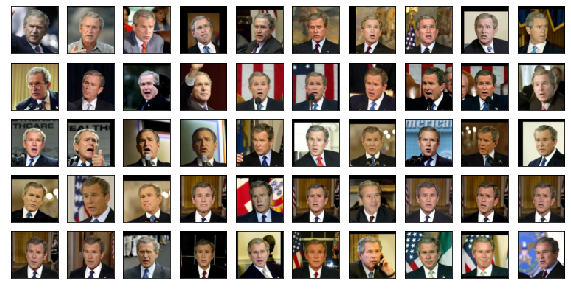

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (features_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(512, 1024, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (flattener): Linear(in_features=16384, out_features=1, bias=True)
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (deflattener): Linear(in_features=128, out_features=16384, bias=True)
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (10): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

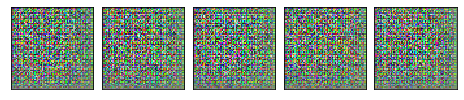

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 8, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.00025}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.003}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.720360889154322
Generator loss:     0.818727573927711


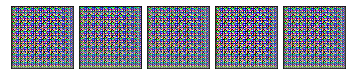

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.94it/s]
Discriminator loss: 1.7876357330995447
Generator loss:     0.7821848602855906


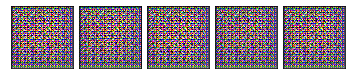

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.916798703810748
Generator loss:     0.745784202042748


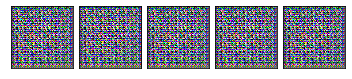

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 1.8558919990763945
Generator loss:     0.8132299535414752


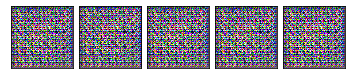

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.43it/s]
Discriminator loss: 1.7860989640740788
Generator loss:     0.8470219268518335


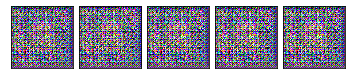

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.69it/s]
Discriminator loss: 1.7181410999859081
Generator loss:     0.8857366057003245


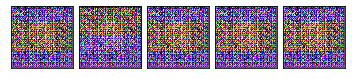

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.5731432718389176
Generator loss:     0.9658527479452246


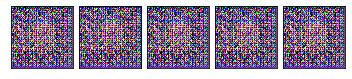

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.92it/s]
Discriminator loss: 1.5160139518625595
Generator loss:     0.9795279047068428


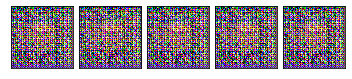

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 1.4787128532634062
Generator loss:     0.9946086091153762


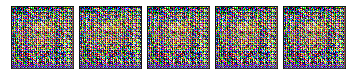

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.457376143511604
Generator loss:     1.0070338073898764


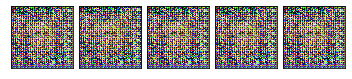

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.4229756453458
Generator loss:     1.0247126747580135


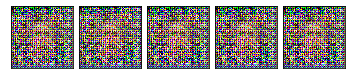

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 1.443529157077565
Generator loss:     1.02441686742446


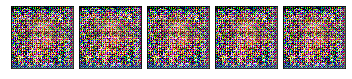

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.51it/s]
Discriminator loss: 1.3385705877752865
Generator loss:     1.072670901522917


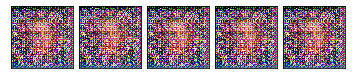

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.3641126857084387
Generator loss:     1.0706489577012903


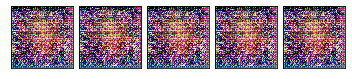

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 1.3750707892810596
Generator loss:     1.0560564959750456


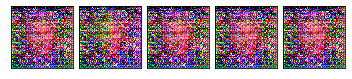

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.3052381557576798
Generator loss:     1.1028825395247515


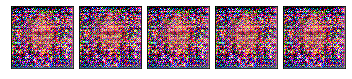

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.3198191067751717
Generator loss:     1.0904880341361551


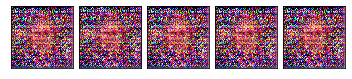

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.79it/s]
Discriminator loss: 1.200652977999519
Generator loss:     1.1823208121692432


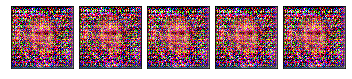

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 1.1424507884418262
Generator loss:     1.2007874530904434


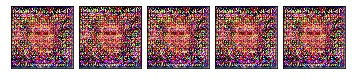

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.12836455597597
Generator loss:     1.2129855787052828


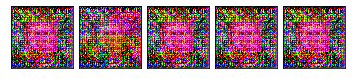

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 1.108185210648705
Generator loss:     1.2155978399164535


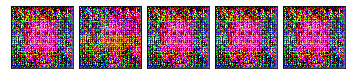

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.53it/s]
Discriminator loss: 1.1154221927418428
Generator loss:     1.225695581997142


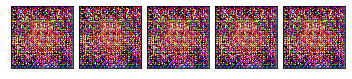

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 1.0610399351400488
Generator loss:     1.2552683002808516


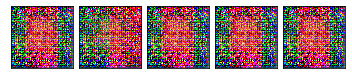

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
Discriminator loss: 1.0464943962938644
Generator loss:     1.261219389298383


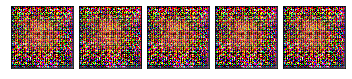

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.0173380655400894
Generator loss:     1.298956324072445


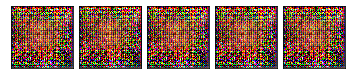

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 0.967446786515853
Generator loss:     1.3447539595996632


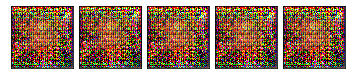

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 0.9368943116244148
Generator loss:     1.3708519865484798


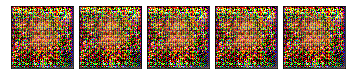

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 0.8451433953116921
Generator loss:     1.4579206144108492


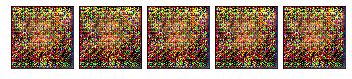

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.97it/s]
Discriminator loss: 0.7843717336654663
Generator loss:     1.5127663822735058


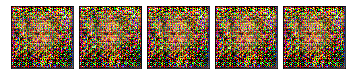

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.7823007001596338
Generator loss:     1.5123060941696167


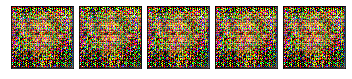

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 0.7889620556550867
Generator loss:     1.544298768043518


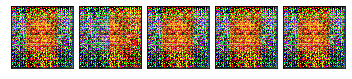

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.98it/s]
Discriminator loss: 0.7709584130960352
Generator loss:     1.5720289314494413


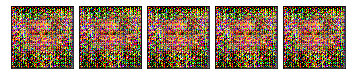

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.7283091685351204
Generator loss:     1.5788155653897453


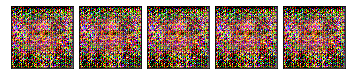

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 0.7174683318418615
Generator loss:     1.6303796137080473


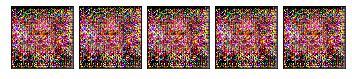

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 0.7034542876131394
Generator loss:     1.6350762493470137


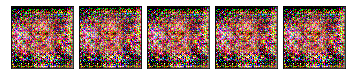

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.76it/s]
Discriminator loss: 0.7401111651869381
Generator loss:     1.6043030724805944


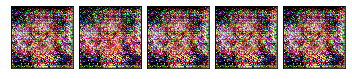

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 0.7749617730869967
Generator loss:     1.5624277381335987


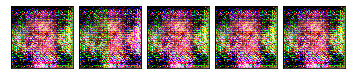

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 0.8367496062727535
Generator loss:     1.5477807802312515


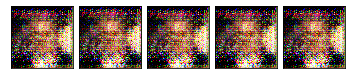

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.1305373065611894
Generator loss:     1.3563258998534258


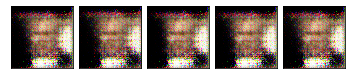

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 1.167376037906198
Generator loss:     1.2900624345330631


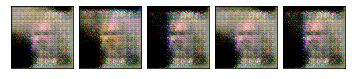

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.60it/s]
Discriminator loss: 1.5121405825895422
Generator loss:     0.9219247909153209


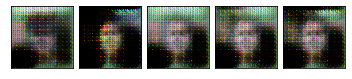

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.692075771443984
Generator loss:     0.8000858636463389


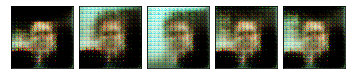

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.43it/s]
Discriminator loss: 1.7933361109565287
Generator loss:     0.7316151366514319


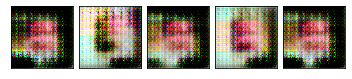

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.01it/s]
Discriminator loss: 1.7447731915642233
Generator loss:     0.6869609811726738


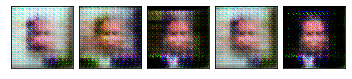

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
Discriminator loss: 1.737591399865992
Generator loss:     0.6429417729377747


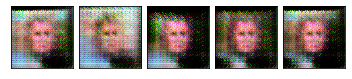

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.892323935733122
Generator loss:     0.5769231529796824


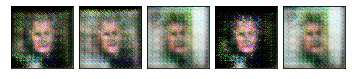

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.8286893157397999
Generator loss:     0.5731241843279671


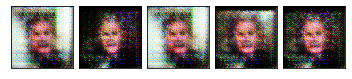

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.72it/s]
Discriminator loss: 1.777986260021434
Generator loss:     0.5825832240721759


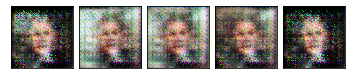

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.58it/s]
Discriminator loss: 1.795826421064489
Generator loss:     0.5785878651282367


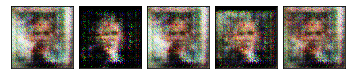

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.65it/s]
Discriminator loss: 1.7551615729051477
Generator loss:     0.5821152048952439


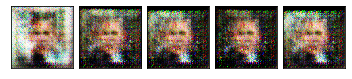

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.7936316097483915
Generator loss:     0.5433807548354653


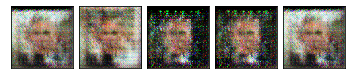

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.8369016577215755
Generator loss:     0.5265980573261485


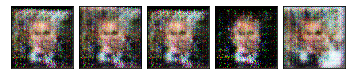

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.70it/s]
Discriminator loss: 1.8584582735510433
Generator loss:     0.5153328916605782


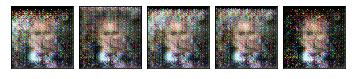

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.8188950384364408
Generator loss:     0.542115197462194


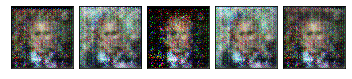

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.67it/s]
Discriminator loss: 1.8157271497389849
Generator loss:     0.5545651912689209


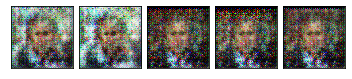

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.66it/s]
Discriminator loss: 1.8392967266194962
Generator loss:     0.5410753593725317


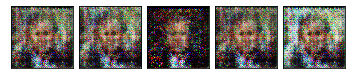

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.8774408663020414
Generator loss:     0.5429959612734178


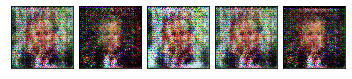

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 1.8293641525156357
Generator loss:     0.5651111041798311


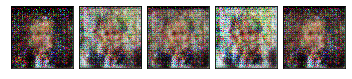

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 1.8576748791862936
Generator loss:     0.5463455389527714


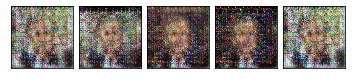

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.12it/s]
Discriminator loss: 1.8441884447546566
Generator loss:     0.5430944667142981


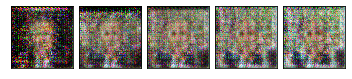

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
Discriminator loss: 1.8338068022447473
Generator loss:     0.5468435462783364


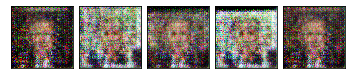

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.37it/s]
Discriminator loss: 1.8331475398119759
Generator loss:     0.5368128594230203


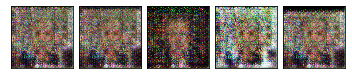

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 1.8371423903633566
Generator loss:     0.5333738607518813


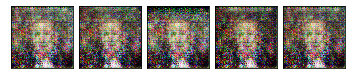

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 1.8203473792356604
Generator loss:     0.5436959301724154


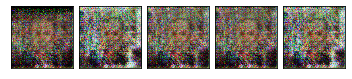

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
Discriminator loss: 1.799290741191191
Generator loss:     0.5444269671159632


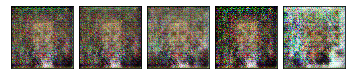

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.7796805956784416
Generator loss:     0.557531896759482


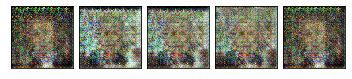

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 1.7376615370021147
Generator loss:     0.5710701942443848


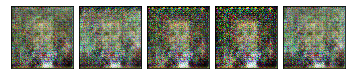

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
Discriminator loss: 1.7364839806276209
Generator loss:     0.5721970901769751


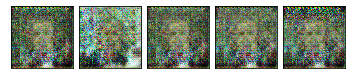

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
Discriminator loss: 1.726151094717138
Generator loss:     0.5850906126639422


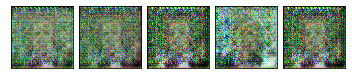

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.7003867556067074
Generator loss:     0.596610798555262


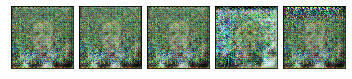

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.6571604083566105
Generator loss:     0.6250057220458984


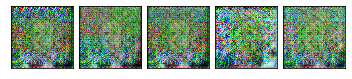

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.06it/s]
Discriminator loss: 1.554036911796121
Generator loss:     0.6825890891692218


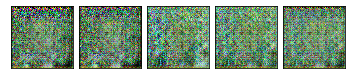

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 1.5216053443796493
Generator loss:     0.6919396133983836


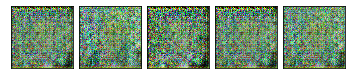

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.4369524927700268
Generator loss:     0.7438929712071138


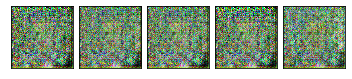

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.10it/s]
Discriminator loss: 1.438964338863597
Generator loss:     0.7344540392651278


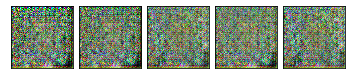

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 1.3894483692505781
Generator loss:     0.7880312940653633


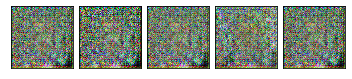

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.54it/s]
Discriminator loss: 1.312915002598482
Generator loss:     0.8508884556153241


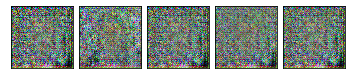

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.71it/s]
Discriminator loss: 1.2629839953254252
Generator loss:     0.8579129155944375


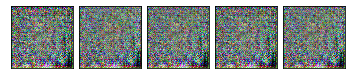

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.63it/s]
Discriminator loss: 1.222596939872293
Generator loss:     0.8755299799582538


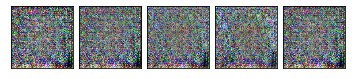

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.64it/s]
Discriminator loss: 1.1925617736928604
Generator loss:     0.9066869371077594


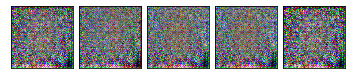

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.51it/s]
Discriminator loss: 1.1828236299402572
Generator loss:     0.8928177567089305


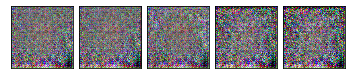

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.56it/s]
Discriminator loss: 1.1833831212099861
Generator loss:     0.9031950375613045


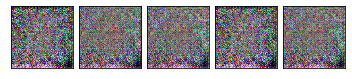

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.55it/s]
Discriminator loss: 1.1930692195892334
Generator loss:     0.915765685193679


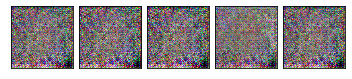

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.61it/s]
Discriminator loss: 1.183224635965684
Generator loss:     0.9055260454907137


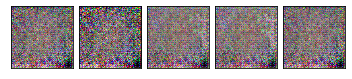

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:05<00:00,  3.72it/s]
Discriminator loss: 1.1710497421376846
Generator loss:     0.9212523137821871


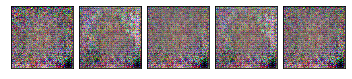

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 1.172615745488335
Generator loss:     0.9299502232495476


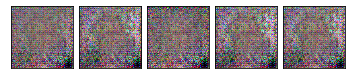

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 1.1169310983489542
Generator loss:     0.9459389448165894


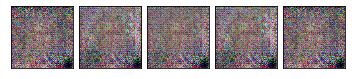

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.02it/s]
Discriminator loss: 1.1913405376322128
Generator loss:     0.8893063313820783


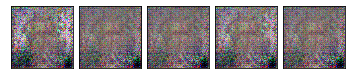

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
Discriminator loss: 1.3421877482358147
Generator loss:     0.7992291485562044


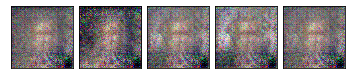

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
Discriminator loss: 1.7188762847115011
Generator loss:     0.5884739721522612


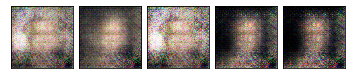

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:04<00:00,  3.99it/s]
Discriminator loss: 1.8047101988511927
Generator loss:     0.5712786422056311


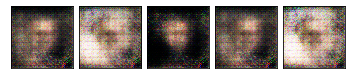

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.28it/s]
Discriminator loss: 1.7621646768906538
Generator loss:     0.6269470172769883


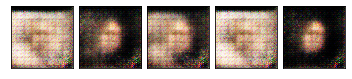

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
Discriminator loss: 1.665239039589377
Generator loss:     0.6668729817166048


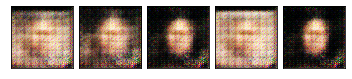

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.16it/s]
Discriminator loss: 1.5604786732617546
Generator loss:     0.6935710240812862


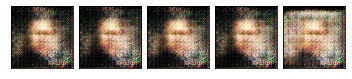

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 1.539681645000682
Generator loss:     0.6511732480105232


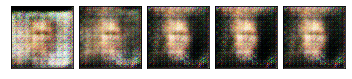

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.15it/s]
Discriminator loss: 1.6300615002127254
Generator loss:     0.5922990230952992


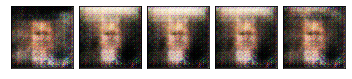

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
Discriminator loss: 1.5834100036060108
Generator loss:     0.6149938527275535


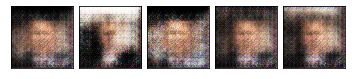

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.04it/s]
Discriminator loss: 1.4862752872354843
Generator loss:     0.6860708909876206


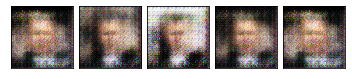

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.05it/s]
Discriminator loss: 1.575568157083848
Generator loss:     0.6195022358613855


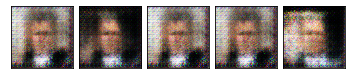

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:04<00:00,  4.08it/s]
Discriminator loss: 1.486981230623582
Generator loss:     0.6799859790241017


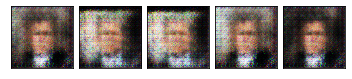

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


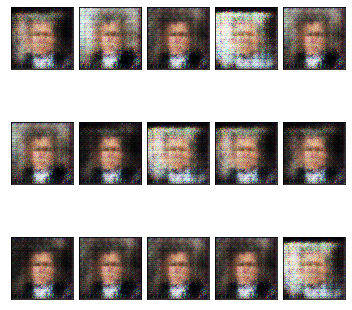

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

